# Primal Optimizer for $C_{1a}$

Multi-strategy optimization for the discretized problem:
$$\min_{x \ge 0,\, \sum x = 1} \max_k \; 2P \sum_{i+j=k} x_i x_j$$

Strategies: (A) L-BFGS-B with many restarts, (B) Polyak subgradient on simplex, (C) Basin hopping.

In [5]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
from scipy.optimize import minimize, basinhopping
import matplotlib.pyplot as plt
from src.representations import StepFunction
from src.convolution import peak_autoconv_exact
from src.objectives import objective_step_fft_valgrad, unpack_step, pack_step

In [6]:
# === Utility functions ===

def project_simplex(x):
    """Project x onto the probability simplex {x >= 0, sum(x) = 1}."""
    n = len(x)
    u = np.sort(x)[::-1]
    cssv = np.cumsum(u) - 1.0
    rho = np.nonzero(u * np.arange(1, n + 1) > cssv)[0][-1]
    tau = cssv[rho] / (rho + 1.0)
    return np.maximum(x - tau, 0.0)


def compute_autoconv_coeffs(x, P):
    """Compute c_k = 2P * sum_{i+j=k} x_i x_j for k=0,...,2(P-1)."""
    c = np.convolve(x, x) * (2 * P)
    return c


def objective_simplex(x, P):
    """max_k c_k for x on the simplex."""
    return np.max(compute_autoconv_coeffs(x, P))


def subgradient_simplex(x, P):
    """Subgradient of max_k c_k w.r.t. x."""
    c = compute_autoconv_coeffs(x, P)
    k_star = np.argmax(c)
    # d(c_{k*})/d(x_i) = 2P * 2 * x_{k*-i} (when k*-i is valid)
    n = len(x)
    g = np.zeros(n)
    for i in range(n):
        j = k_star - i
        if 0 <= j < n:
            g[i] += 2 * (2 * P) * x[j]
    return g


def fft_grid_size(P):
    """Choose n_grid large enough to resolve all ~P^2 autoconvolution breakpoints."""
    return max(8192, 4 * P * P)


# === Strategy A: L-BFGS-B with many restarts ===

def strategy_a(P, n_restarts=150):
    edges = np.linspace(-0.25, 0.25, P + 1)
    n_grid = fft_grid_size(P)
    best_val = np.inf
    best_params = None
    scales = [0.1, 0.3, 0.5, 1.0, 2.0]
    for i in range(n_restarts):
        scale = scales[i % len(scales)]
        p0 = np.random.randn(P) * scale
        try:
            res = minimize(objective_step_fft_valgrad, p0, args=(edges, n_grid),
                           method='L-BFGS-B', jac=True,
                           options={'maxiter': 500, 'ftol': 1e-12, 'gtol': 1e-8})
            if res.fun < best_val:
                best_val = res.fun
                best_params = res.x
        except Exception:
            continue
    sf = unpack_step(best_params, edges)
    return best_val, sf.heights.copy()


# === Strategy B: Polyak subgradient on the simplex ===

def strategy_b(P, n_iters=50000, n_restarts=10, targets=(1.50, 1.49, 1.48)):
    best_val = np.inf
    best_x = None
    for target in targets:
        for restart in range(n_restarts):
            # Random Dirichlet initialization to break symmetry
            x = np.random.dirichlet(np.ones(P))
            best_local = np.inf
            best_local_x = x.copy()
            for t in range(n_iters):
                fval = objective_simplex(x, P)
                if fval < best_local:
                    best_local = fval
                    best_local_x = x.copy()
                g = subgradient_simplex(x, P)
                gnorm2 = np.dot(g, g)
                if gnorm2 < 1e-20:
                    break
                step = (fval - target) / gnorm2
                if step < 0:
                    step = 1e-4 / (1 + t)  # fallback diminishing step
                x = project_simplex(x - step * g)
            if best_local < best_val:
                best_val = best_local
                best_x = best_local_x.copy()
    return best_val, best_x


# === Strategy C: Basin hopping ===

def strategy_c(P, niter=200, T=0.1):
    edges = np.linspace(-0.25, 0.25, P + 1)
    n_grid = fft_grid_size(P)
    p0 = np.random.randn(P) * 0.5
    minimizer_kwargs = {
        'method': 'L-BFGS-B', 'jac': True, 'args': (edges, n_grid),
        'options': {'maxiter': 300, 'ftol': 1e-12, 'gtol': 1e-8}
    }
    res = basinhopping(objective_step_fft_valgrad, p0,
                       minimizer_kwargs=minimizer_kwargs,
                       niter=niter, T=T, seed=42)
    sf = unpack_step(res.x, edges)
    return res.fun, sf.heights.copy()


print("Strategies defined.")

Strategies defined.


In [7]:
# === Sweep over P values ===

P_values = [10, 20, 30, 50, 75, 100, 150, 200]
results = {}  # P -> {strategy_name: (val, heights), 'best': (val, heights, name)}

for P in P_values:
    print(f"\n{'='*60}")
    print(f"P = {P}")
    print(f"{'='*60}")
    
    res_p = {}
    edges = np.linspace(-0.25, 0.25, P + 1)
    
    # Strategy A
    print(f"  Strategy A (L-BFGS-B, 150 restarts)...", end=' ')
    val_a, h_a = strategy_a(P)
    # Validate with exact peak
    sf_a = StepFunction.from_heights(edges, h_a)
    exact_a = peak_autoconv_exact(sf_a)
    print(f"FFT={val_a:.6f}, exact={exact_a:.6f}")
    res_p['A'] = (exact_a, h_a)
    
    # Strategy B
    print(f"  Strategy B (Polyak subgradient)...", end=' ')
    val_b, h_b = strategy_b(P)
    # h_b is on simplex (sums to 1), convert to heights (divide by bin width)
    bin_width = 0.5 / P
    sf_b = StepFunction.from_heights(edges, h_b / bin_width)
    exact_b = peak_autoconv_exact(sf_b)
    print(f"obj={val_b:.6f}, exact={exact_b:.6f}")
    res_p['B'] = (exact_b, (h_b / bin_width).copy())
    
    # Strategy C
    print(f"  Strategy C (Basin hopping)...", end=' ')
    val_c, h_c = strategy_c(P)
    sf_c = StepFunction.from_heights(edges, h_c)
    exact_c = peak_autoconv_exact(sf_c)
    print(f"FFT={val_c:.6f}, exact={exact_c:.6f}")
    res_p['C'] = (exact_c, h_c)
    
    # Best across strategies
    best_name = min(res_p, key=lambda k: res_p[k][0])
    best_val, best_h = res_p[best_name]
    print(f"  >> Best: Strategy {best_name}, exact={best_val:.6f}")
    res_p['best'] = (best_val, best_h, best_name)
    
    results[P] = res_p


P = 10
  Strategy A (L-BFGS-B, 150 restarts)... FFT=1.584644, exact=1.584752
  Strategy B (Polyak subgradient)... obj=1.569309, exact=1.569309
  Strategy C (Basin hopping)... FFT=1.575732, exact=1.575346
  >> Best: Strategy B, exact=1.569309

P = 20
  Strategy A (L-BFGS-B, 150 restarts)... FFT=1.600865, exact=1.601094
  Strategy B (Polyak subgradient)... obj=1.542988, exact=1.542988
  Strategy C (Basin hopping)... FFT=1.572192, exact=1.573063
  >> Best: Strategy B, exact=1.542988

P = 30
  Strategy A (L-BFGS-B, 150 restarts)... FFT=1.589079, exact=1.589412
  Strategy B (Polyak subgradient)... obj=1.529321, exact=1.529321
  Strategy C (Basin hopping)... FFT=1.578300, exact=1.578315
  >> Best: Strategy B, exact=1.529321

P = 50
  Strategy A (L-BFGS-B, 150 restarts)... FFT=1.626003, exact=1.626003
  Strategy B (Polyak subgradient)... obj=1.520036, exact=1.520036
  Strategy C (Basin hopping)... FFT=1.591759, exact=1.591759
  >> Best: Strategy B, exact=1.520036

P = 75
  Strategy A (L-BFGS

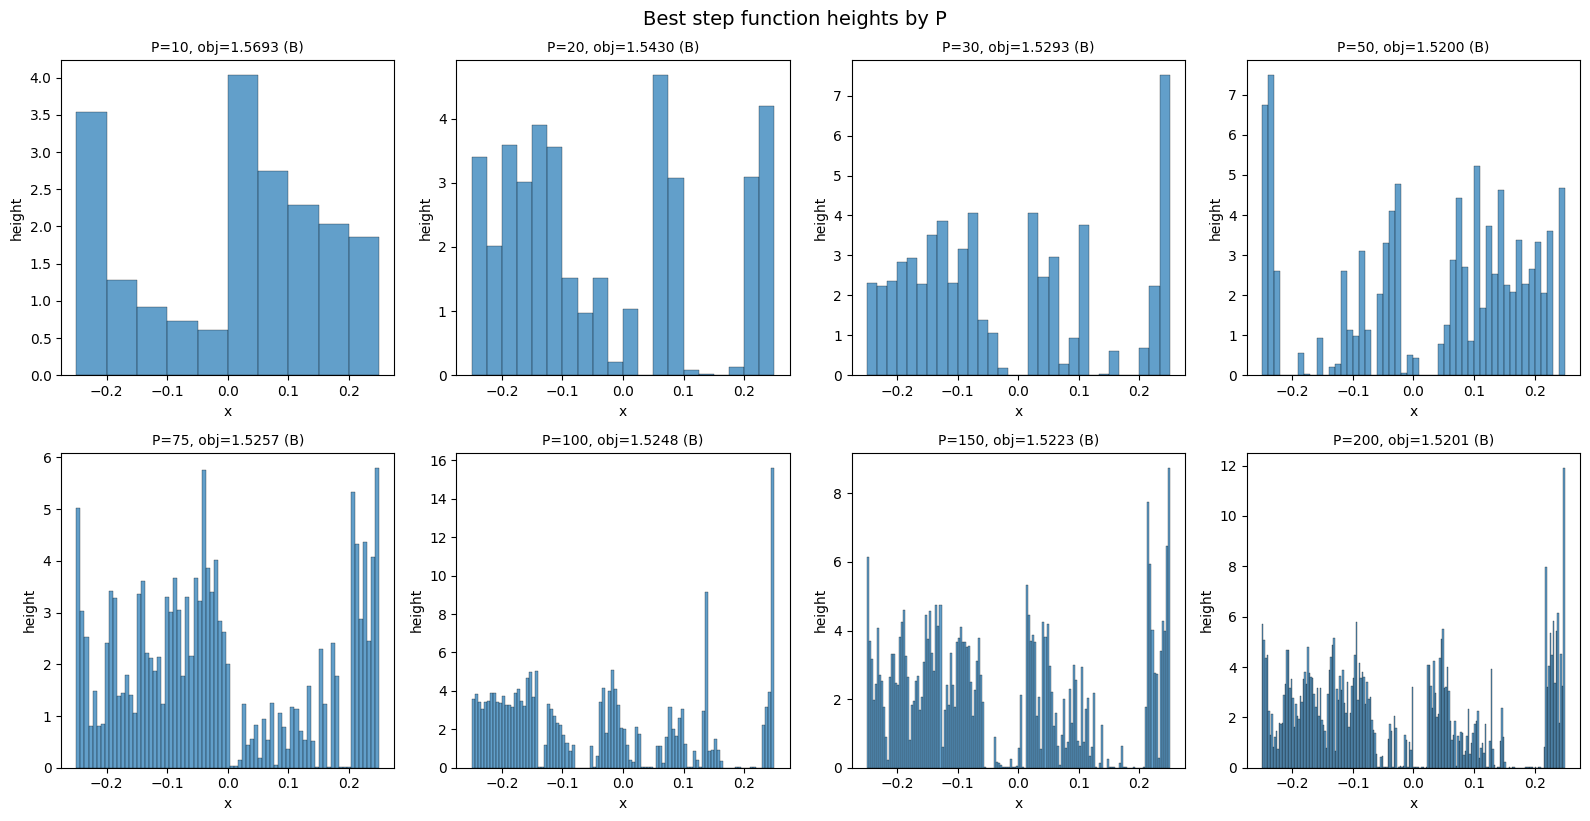

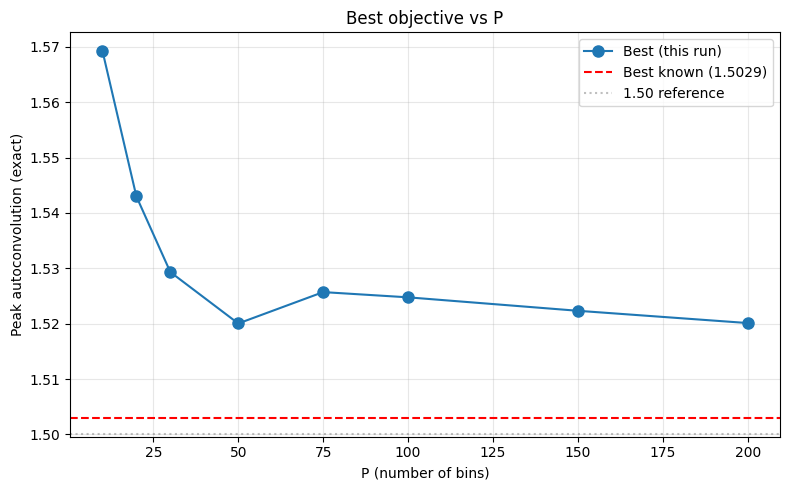

In [8]:
# === Analysis: plot best solutions ===

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, P in enumerate(P_values):
    ax = axes[idx]
    best_val, best_h, best_name = results[P]['best']
    edges = np.linspace(-0.25, 0.25, P + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    ax.bar(centers, best_h, width=0.5/P, alpha=0.7, edgecolor='k', linewidth=0.3)
    ax.set_title(f'P={P}, obj={best_val:.4f} ({best_name})', fontsize=10)
    ax.set_xlabel('x')
    ax.set_ylabel('height')

plt.tight_layout()
plt.suptitle('Best step function heights by P', y=1.02, fontsize=14)
plt.show()

# Objective vs P
fig, ax = plt.subplots(figsize=(8, 5))
Ps = sorted(results.keys())
best_vals = [results[P]['best'][0] for P in Ps]
ax.plot(Ps, best_vals, 'o-', label='Best (this run)', markersize=8)
ax.axhline(1.5029, color='r', linestyle='--', label='Best known (1.5029)')
ax.axhline(1.50, color='gray', linestyle=':', alpha=0.5, label='1.50 reference')
ax.set_xlabel('P (number of bins)')
ax.set_ylabel('Peak autoconvolution (exact)')
ax.set_title('Best objective vs P')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# === Results table ===

print(f"{'P':>5} | {'Strategy A':>12} | {'Strategy B':>12} | {'Strategy C':>12} | {'Best':>12} | {'Best known':>12}")
print('-' * 78)
for P in P_values:
    r = results[P]
    va = r['A'][0]
    vb = r['B'][0]
    vc = r['C'][0]
    vbest = r['best'][0]
    best_name = r['best'][2]
    print(f"{P:>5} | {va:>12.6f} | {vb:>12.6f} | {vc:>12.6f} | {vbest:>10.6f} ({best_name}) | {1.5029:>12.4f}")

print()
print("Summary:")
for P in P_values:
    vbest = results[P]['best'][0]
    gap = vbest - 1.5029
    print(f"  P={P:>3}: best = {vbest:.6f}, gap to 1.5029 = {gap:+.6f}")

    P |   Strategy A |   Strategy B |   Strategy C |         Best |   Best known
------------------------------------------------------------------------------
   10 |     1.584752 |     1.569309 |     1.575346 |   1.569309 (B) |       1.5029
   20 |     1.601094 |     1.542988 |     1.573063 |   1.542988 (B) |       1.5029
   30 |     1.589412 |     1.529321 |     1.578315 |   1.529321 (B) |       1.5029
   50 |     1.626003 |     1.520036 |     1.591759 |   1.520036 (B) |       1.5029
   75 |     1.593709 |     1.525705 |     1.569669 |   1.525705 (B) |       1.5029
  100 |     1.596125 |     1.524759 |     1.585707 |   1.524759 (B) |       1.5029
  150 |     1.601768 |     1.522328 |     1.592396 |   1.522328 (B) |       1.5029
  200 |     1.608391 |     1.520114 |     1.596509 |   1.520114 (B) |       1.5029

Summary:
  P= 10: best = 1.569309, gap to 1.5029 = +0.066409
  P= 20: best = 1.542988, gap to 1.5029 = +0.040088
  P= 30: best = 1.529321, gap to 1.5029 = +0.026421
  P= 50: b